# Testowanie ustawień dla sieci

In [127]:
#import pytorch as py
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import json


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


from skimage.transform import resize


In [3]:
# Opening JSON file
f = open('data/reference_images_part1.json')
  
# returns JSON object as 
# a dictionary
img_info = json.load(f)

In [4]:
for key, value in img_info.items() :
    print (key)

images
annotations
categories


In [5]:
img_info["annotations"][0]["id"]

12

In [292]:
import json
import pandas as pd
import imageio


def load_data(mode):
    if mode == 'TRAIN':
        json_path = 'data/reference_images_part1.json'
        images_path = 'data/reference_images_part1/'
    elif mode == 'VAL':
        json_path = 'data/images_part1_valid.json'
        images_path = 'data/images_part1_valid/'
    else:
        raise ValueError('usupported mode')
    with open(json_path) as json_data:
        data = json.load(json_data)
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])

    df = pd.DataFrame()

    X = []
    y = []
    y_desc = []

    for instance in data['annotations']:

        if categories.loc[categories['id'] == instance['category_id']]['name'].values[0] == 7 or categories.loc[categories['id'] == instance['category_id']]['name'].values[0] == 14 or categories.loc[categories['id'] == instance['category_id']]['name'].values[0] == 28:
           None
        else:
            im_id = instance['image_id']
            bbox = instance['bbox']
            for i in range(len(bbox)):
                bbox[i] = int(bbox[i])
            y.append(instance['category_id'])

            im = imageio.imread(
                images_path+images.loc[images['id'] == im_id]['file_name'].values[0])
            X.append(im[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]])
            y_desc.append(
                categories.loc[categories['id'] == instance['category_id']]['name'].values[0])

    df['X'] = X
    df['y'] = y
    df['desc'] = y_desc

    return df


In [293]:
def normalize(x):
    return x/255

df_val = load_data("VAL")
df = load_data("TRAIN")
df["X"] = df["X"].apply(normalize) 
df_val["X"] = df_val["X"].apply(normalize) 


print(df.shape)

(144, 3)


In [294]:
print(np.unique(df["y"])==np.unique(df_val["y"]))

False


C:\Users\kaczm\AppData\Local\Temp/ipykernel_15336/2307611478.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.unique(df["y"])==np.unique(df_val["y"]))


## Budowanie modelu

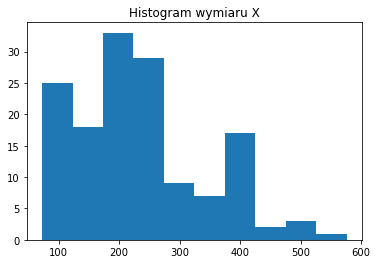

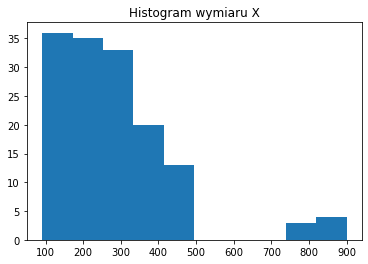

min max X = 73.0, 576.0
min max Y = 91.0, 900.0


In [ ]:
X = np.zeros(len(df))
Y = np.zeros(len(df))
for i in range(len(df)):
    X[i] = df['X'][i].shape[0]
    Y[i] = df['X'][i].shape[1]

plt.hist(X)
plt.title("Histogram wymiaru X")
plt.show()
plt.title("Histogram wymiaru X")
plt.hist(Y)
plt.show()

print(f"min max X = {np.min(X)}, {np.max(X)}")
print(f"min max Y = {np.min(Y)}, {np.max(Y)}")


In [295]:
def preprocessing(df):
    data_x = np.zeros((len(df),256,256,3))
    data_y = np.zeros((len(df),1))
    mean=0
    for i in range(len(df)):
        data_y[i] = df['y'][i]
        temp_df = np.array(df['X'][i][:,:,0:3])
        temp_df_shape = np.array(df['X'][i][:,:,0:3]).shape

        mean += np.mean(temp_df)
        max_shape = np.max(temp_df_shape)
        max_shape_orient = np.where(temp_df_shape==max_shape) # zwróci 0 albo 1
        temp_arr = np.zeros((max_shape,max_shape,3)) ## mozna czymś wypełnić tło

        if max_shape_orient[0][0] == 0:
            t = (temp_df_shape[0] - temp_df_shape[1])//2
            temp_arr[:,t:t+temp_df_shape[1],:] = temp_df

        elif max_shape_orient[0][0] == 1:
            t = (temp_df_shape[1] - temp_df_shape[0])//2
            temp_arr[t:t+temp_df_shape[0],:,:] = temp_df
        

        data_x[i] = resize(temp_arr, (256, 256))

    data_x = np.where(data_x==0,mean/i,data_x)
            


    return data_x, data_y

In [296]:
data_x, data_y = preprocessing(df)

data_x_val, data_y_val = preprocessing(df_val)


(144, 256, 256, 3)
(144, 1)
13.0


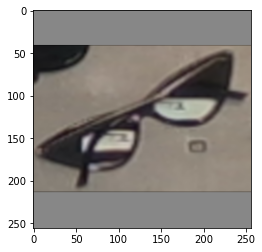

In [297]:
plt.imshow(data_x[24])

print(data_x.shape)

print(data_y.shape)
print(np.max(data_y))

In [304]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [305]:
def mobilenet(input_shape:int, output_channels:int):
  inputs = tf.keras.layers.Input(shape=[input_shape, input_shape, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

 
  # This is the last layer of the model
  last = tf.keras.layers.Flatten()
  
  

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [307]:
model = mobilenet(256,14)
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 model_23 (Functional)       [(None, 128, 128, 96),    1841984   
                              (None, 64, 64, 144),               
                              (None, 32, 32, 192),               
                              (None, 16, 16, 576),               
                              (None, 8, 8, 320)]                 
                                                                 
 flatten_22 (Flatten)        (None, 20480)             0         
                                                                 
Total params: 1,841,984
Trainable params: 0
Non-trainable params: 1,841,984
_________________________________________________________________


In [ ]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=25, algorithm='ball_tree').fit(preds)
distances, indices = nbrs.kneighbors(preds)

arr = nbrs.kneighbors_graph(preds).toarray()

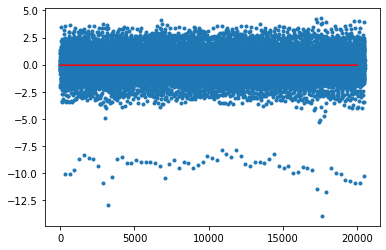

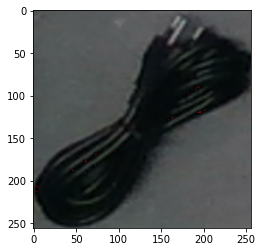

(1, 66)


In [314]:
n = 100

preds = model.predict(data_x)
plt.plot(preds[n],'.')

yy = np.zeros(20000)
yy[:] = np.mean(preds)
plt.plot(np.arange(20000),yy,"r")


plt.show()

plt.imshow(data_x[n])
plt.show()
print(preds[n,np.where(np.abs(preds[n,:])>5)].shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(preds, data_y)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


AttributeError: 'KNeighborsClassifier' object has no attribute 'radius_neighbors_graph'

In [308]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


pca.fit(model)

pca_proj = pca.transform(model)

TypeError: float() argument must be a string or a number, not 'Functional'

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.003s...
[t-SNE] Computed neighbors for 144 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 21.363344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.759708
[t-SNE] KL divergence after 1000 iterations: 0.308217
(144, 2)


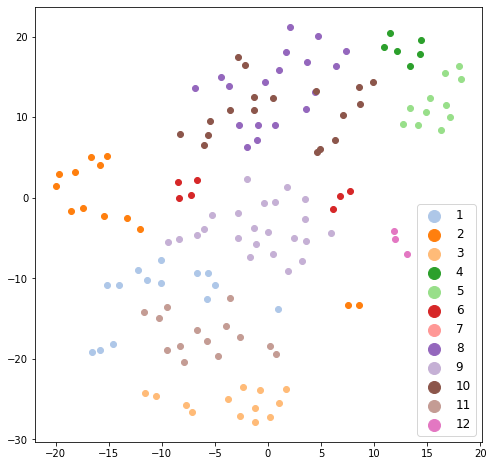

In [338]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

emb_v2 = model(data_x)
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(emb_v2)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 13

print(tsne_proj.shape)


for lab in range(1,num_categories):
    indices =data_y==lab
    ax.scatter(tsne_proj[indices[:,0],0],tsne_proj[indices[:,0],1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=1)
ax.legend(fontsize='large', markerscale=2)

plt.show()
